AutoEncoder

In [1]:
#from IPython.display import Image
#Image(filename='ae.png')

In [2]:
# =========================================================================
# Date : 29 nov. 2018
# MS Valdom > apprenants > omar attaf, laurent lapasset, didier le picaut
# Version = 1.0
# =========================================================================

In [3]:
# Syllabus - auto encoder (AE)
# http://www.xavierdupre.fr/app/ensae_teaching_dl/helpsphinx//chapters/deep_apprentissage_sans_labels.html

In [4]:
# =================
# autocompletion
# =================
%config IPCompleter.greedy=True

In [5]:
# importer les libraries
from __future__ import print_function
import argparse

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [6]:
#== mise en place d un compteur de temps pour voir le temps de convergence du Rx neurones [trop  ou pas ?]
# Debut du decompte du temps
import time
start_time = time.time()

In [7]:
#== sanity check : library cuda est-elle presente ?
torch.cuda.is_available()

True

In [8]:
#== sanity check : presence du framework cudnn ?
torch.backends.cudnn.enabled

True

In [9]:
# reproductible
SEED = 1
torch.manual_seed(SEED)

In [10]:
batchsize = 128

#epochs=10
epochs=200

loginterval=10
cuda = torch.cuda.is_available()

In [11]:
device = torch.device("cuda" if cuda else "cpu")
device

device(type='cuda')

In [12]:
#== data chargement > dataset train + dataset test
# Téléchargez ou chargez le jeu de données MNIST téléchargé 
# mélangez les données à chaque époque 


# Les instances de DataLoader chargeront les tenseurs directement dans la mémoire du GPU 

kwargs = {'num_workers': 11, 'pin_memory': True} if cuda else {}

# dataset train

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

# dataset test

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

In [13]:
len(train_loader.dataset)

60000

In [14]:
len(test_loader.dataset)

10000

In [15]:
#== transform=transforms.ToTensor()) ?

# Convertit une image PIL ou numpy.ndarray (H x L x C) 
# comprise dans l'intervalle [0, 255] en une torche.
# Tensoriseur de forme (C x H x W) compris dans l'intervalle [0.0, 1.0].


In [16]:
#== creation du modele

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
# ENCODEUR 
# 28 x 28 pixels = 784 pixels en entrée, 400 sorties
# couche unitaire linéaire rectifiée de 400 à 400 

        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400,20) # espace latent = couche cachee
            )

# DECODEUR 
# de goulot d' étranglement à 400 caché
# on fait le travail autre-sens
    
        self.decoder = nn.Sequential(
            nn.Linear(20,400),
            nn.ReLU(),
            nn.Linear(400,784),
            )

        # create using nn.Sequential()
        # encoder :FullyConnected (784 -> 400), RELU activation; FC (400, 20)
        # decoder :FullyConnected (20 -> 400), RELU activation; FC (400, 784)
        

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        xview = x.view((-1, 784))
        z = self.encode(xview)
        return self.decode(z)

model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.view.html
# otimizer utilise = adam

In [18]:
def loss_function(recon_batch, x):
    
    # compute bce as the binary cross entropy across the batch as a sum
    # L'entrée est binarisée et Binary Cross Entropy a été utilisé comme fonction de perte.
    # dans quelle mesure l'entrée x et la sortie recon_x sont-elles d'accord?
    
    loss = torch.nn.BCELoss(reduction='sum')
    return loss(recon_batch, x)

In [19]:
losses = []

def train(epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data.view(-1,784))
        losses.append(loss.cpu().item())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
          train_loss / len(train_loader.dataset)), end='')

In [20]:
def test(epoch):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data.view(-1, 784))

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchsize, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

In [21]:
# results/reconstruction = les images sont reconstruites et images stockees ds le fichier 

In [22]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    
# digits in latent space
# enregistrer en tant que matrice 8 × 8 = 64 de MNIST chiffres    
    with torch.no_grad():
     sample = torch.randn(64, 20).to(device)
     sample = model.decode(sample).cpu()
     save_image(sample.view(64, 1, 28, 28), 'results/sample_' + str(epoch) + '.png')

 Train Epoch: 1 [58880/60000 (98%)]	Loss: 90.7 Average loss: 132.0 Test loss: 89.0
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 84.4 Average loss: 83.4 Test loss: 78.1
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 76.9 Average loss: 77.0 Test loss: 74.5
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 76.2 Average loss: 74.2 Test loss: 72.6
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 73.3 Average loss: 72.4 Test loss: 71.4
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 69.6 Average loss: 71.1 Test loss: 70.2
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 69.8 Average loss: 70.2 Test loss: 69.4
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 71.2 Average loss: 69.4 Test loss: 68.8
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 68.4 Average loss: 68.8 Test loss: 68.5
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 69.2 Average loss: 68.3 Test loss: 68.1
 Train Epoch: 11 [58880/60000 (98%)]	Loss: 67.3 Average loss: 67.8 Test loss: 67.7
 Train Epoch: 12 [58880/60000 (98%)]	Loss: 69.2 Average loss: 67.4 Test loss: 67.3
 Train Epoch

 Train Epoch: 100 [58880/60000 (98%)]	Loss: 63.0 Average loss: 62.3 Test loss: 63.7
 Train Epoch: 101 [58880/60000 (98%)]	Loss: 64.1 Average loss: 62.3 Test loss: 63.8
 Train Epoch: 102 [58880/60000 (98%)]	Loss: 62.3 Average loss: 62.2 Test loss: 63.9
 Train Epoch: 103 [58880/60000 (98%)]	Loss: 64.0 Average loss: 62.2 Test loss: 64.0
 Train Epoch: 104 [58880/60000 (98%)]	Loss: 59.8 Average loss: 62.2 Test loss: 63.8
 Train Epoch: 105 [58880/60000 (98%)]	Loss: 62.2 Average loss: 62.2 Test loss: 63.9
 Train Epoch: 106 [58880/60000 (98%)]	Loss: 63.3 Average loss: 62.2 Test loss: 63.9
 Train Epoch: 107 [58880/60000 (98%)]	Loss: 65.0 Average loss: 62.2 Test loss: 63.8
 Train Epoch: 108 [58880/60000 (98%)]	Loss: 59.8 Average loss: 62.2 Test loss: 63.8
 Train Epoch: 109 [58880/60000 (98%)]	Loss: 61.2 Average loss: 62.2 Test loss: 63.8
 Train Epoch: 110 [58880/60000 (98%)]	Loss: 62.2 Average loss: 62.2 Test loss: 63.7
 Train Epoch: 111 [58880/60000 (98%)]	Loss: 60.9 Average loss: 62.1 Test los

 Train Epoch: 197 [58880/60000 (98%)]	Loss: 59.0 Average loss: 61.5 Test loss: 63.7
 Train Epoch: 198 [58880/60000 (98%)]	Loss: 63.5 Average loss: 61.5 Test loss: 63.7
 Train Epoch: 199 [58880/60000 (98%)]	Loss: 61.1 Average loss: 61.6 Test loss: 63.6
 Train Epoch: 200 [58880/60000 (98%)]	Loss: 59.5 Average loss: 61.5 Test loss: 63.6


In [23]:
# controle de results
# dans fichier results : 200 images codees + 200 images decodees pour 200 epochs
# sur chaque image (suite de 8 chiffres encodes > 8  chiffres decodes)

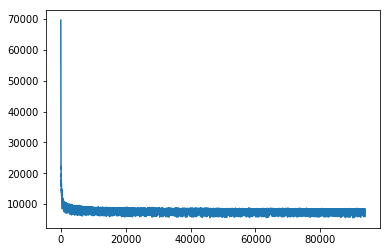

In [24]:
#plot losses
plt.plot(losses)

In [25]:
# Affichage du temps d execution
print("Temps d execution : %s secondes ---" % round((time.time() - start_time),1))

Temps d execution : 297.5 secondes ---


In [ ]:
# analyse : 5 mn avec 1 geforce gtx1080